In [2]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

In [3]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
speech2vec = KeyedVectors.load_word2vec_format('../../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False)
vocab = list(speech2vec.vocab.keys())

In [5]:
d = {
    'A':'dot dash',
    'B':'dash dot dot dot',
    'C':'dash dot dash dot',
    'D':'dash dot dot',
    'E':'dot',
    'F':'dot dot dash dot',
    'G':'dash dash dot',
    'H':'dot dot dot dot',
    'I':'dot dot',
    'J':'dot dash dash dash',
    'K':'dash dot dash',
    'L':'dot dash dot dot',
    'M':'dash dash',
    'N':'dash dot',
    'O':'dash dash dash',
    'P':'dot dash dash dot',
    'Q':'dash dash dot dash',
    'R':'dot dash dot',
    'S':'dot dot dot',
    'T':'dash',
    'U':'dot dot dash',
    'V':'dot dot dot dash',
    'W':'dot dash dash',
    'X':'dash dot dot dash',
    'Y':'dash dot dash dash',
    'Z':'dash dash dot dot',
    '\'':'dot dash dash dash dash dot'
}
# dot=1
# dash=3
# space=1
# between letters = 3
# between words = 4

SR = 16000

unit = 0.15
u = np.linspace(0, unit, int(unit*SR))
dot = np.sin(2 * np.pi * 440 * u)
spot = np.zeros_like(u)
dot.shape, spot.shape

m = {
    'dot': dot,
    ' ': spot,
    'dash': np.concatenate([dot, dot, dot]),
    r'/': np.concatenate([spot, spot, spot])
}

def word2morseword(word):
    morseword = ''
    for i, letter in enumerate(word):
        if i == 0:
            morseword += d[letter]
        else:
            morseword += '/'
            morseword += d[letter]
    return morseword

def morseword2morseaudio(morseword):
    morseaudio = []
    for i, morseletter in enumerate(re.split('/', morseword)):
        if i == 0:
            for j, feature in enumerate(re.split('\s', morseletter)):
                if j == 0:
                    morseaudio.append(m[feature])
                else:
                    morseaudio.append(m[' '])
                    morseaudio.append(m[feature])
        else:
            morseaudio.append(m[r'/'])
            for j, feature in enumerate(re.split('\s', morseletter)):
                if j == 0:
                    morseaudio.append(m[feature])
                else:
                    morseaudio.append(m[' '])
                    morseaudio.append(m[feature])
    morseaudio = np.concatenate(morseaudio)
    return morseaudio
    
def word2morse(word):
    morseword = word2morseword(word)
    morse = morseword2morseaudio(morseword)
    return morse

def show_spectrogram(morse):
    S = librosa.stft(morse, n_fft=1024, hop_length=1024//16)
    plt.imshow(np.abs(S), aspect='auto')
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()
    display(Audio(morse, rate=SR))

In [6]:
from IPython.lib.display import Audio

In [7]:
import librosa

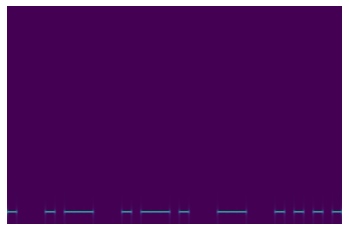

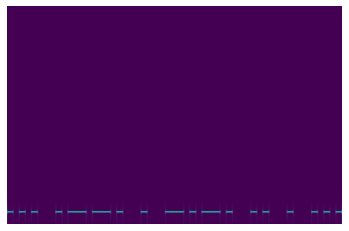

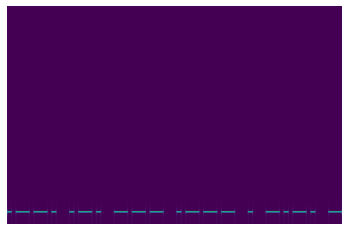

In [8]:
morsecat = word2morse('EARTH')
show_spectrogram(morsecat)
morsecat = word2morse('SPECIES')
show_spectrogram(morsecat)
morsecat = word2morse('PROJECT')
show_spectrogram(morsecat)

In [9]:
original = word2morse('ENCODING')
encoded = librosa.mu_compress(original, mu=2**5-1, quantize=True)

In [10]:
print('Original:')
display(Audio(original, rate=SR))
print('Encoded:')
display(Audio(encoded, rate=SR))

Original:


Encoded:


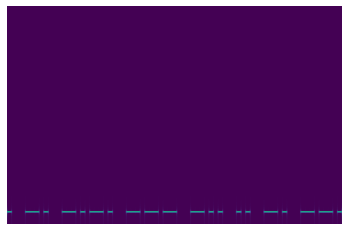

In [11]:
show_spectrogram(original)

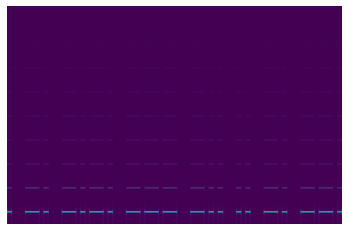

In [12]:
show_spectrogram(encoded.astype('float32'))

In [13]:
word2morseword(vocab[0].upper())

'dash/dot dot dot dot/dot'

In [14]:
m = {
    'dot': [1],
    ' ': [0],
    'dash': [1,1,1],
    r'/': [0,0,0]
}

In [15]:
def morseword2array(word):
    str_representation = word2morseword(word)
    ary = []
    for letter in str_representation.split('/'):
        for character in letter.split(' '):
            ary += m[character]
            ary += m[' ']
        ary += m['/']
    return np.array(ary).reshape(-1, 1)

In [16]:
morseword2array(vocab[0].upper())

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0]])

In [17]:
word2features = {word: morseword2array(word.upper()) for word in vocab}

In [18]:
max_length = 0
for word, features in  word2features.items():
    max_length = max(max_length, features.shape[0])

In [19]:
max_length

190

In [20]:
def prepare_features(word, pad_to=190, pad_left=True):
    ary = word2features[word]
    example = np.zeros((pad_to, 1))
    if pad_left:
        example[-ary.shape[0]:, :] = ary
    else: example[:ary.shape[0], :] = ary
    return example.astype(np.float32)

In [21]:
prepare_features(vocab[0]).shape

(190, 1)

In [22]:
word2idx = {word: idx for idx, word in enumerate(vocab)}

In [23]:
class Dataset():
    def __init__(self, mult=10):
        self.mult = mult
    def __len__(self):
        return self.mult * len(vocab)
    def __getitem__(self, idx):
        idx %= len(vocab)
        word = vocab[idx]
        return prepare_features(word), word2idx[word]

In [24]:
train_ds = Dataset(10)
valid_ds = Dataset(1)

len(train_ds), len(valid_ds)

(376220, 37622)

In [25]:
BS = 1024
NUM_WORKERS = 8

train_dl = DataLoader(train_ds, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(valid_ds, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [26]:
# Got the following error while training:

# DataLoader worker (pid 2073) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.
# trying the solution I found here: https://github.com/pytorch/pytorch/issues/5040
# which is to execute
!sudo umount /dev/shm/ && sudo mount -t tmpfs -o rw,nosuid,nodev,noexec,relatime,size=50G shm /dev/shm

umount: /dev/shm/: target is busy
        (In some cases useful info about processes that
         use the device is found by lsof(8) or fuser(1).)


In [27]:
class Model(Module):
    def __init__(self, hidden_size=150):
        self.return_embeddings = False
        self.hidden_size = hidden_size
        
        self.encoder= nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=True
        )
        
        self.linear = nn.Linear(2*hidden_size, len(vocab))
            
    def forward(self, source_features):
        _, (embeddings, _) = self.encoder(source_features)      
        
        # embeddings.view(num_layers, num_directions, batch, hidden_size)
        embeddings = embeddings.view(1, 2, source_features.shape[0], self.hidden_size)
        embeddings = torch.cat((embeddings[-1, 0], embeddings[-1, 1]), -1)
        
        if self.return_embeddings: return embeddings
        return self.linear(embeddings)

In [28]:
learn = Learner(
    dls.cuda(),
    Model().cuda(),
    loss_func=CrossEntropyLossFlat(),
    opt_func=Adam,
    metrics=[accuracy]
)

In [35]:
learn.fit(10, lr=1e-3, cbs=SaveModelCallback(fname='morse', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,10.296154,10.009776,0.000319,00:31
1,9.256577,9.009649,0.001143,00:31
2,8.590598,8.333588,0.004545,00:31
3,7.914754,7.672571,0.014034,00:31
4,6.347895,6.038644,0.054224,00:30
5,5.455032,5.151983,0.123066,00:31
6,4.823102,4.553427,0.175562,00:31
7,4.268623,3.993842,0.247462,00:31
8,3.781415,3.516114,0.326750,00:31
9,3.307771,3.025243,0.428313,00:31


In [36]:
learn.fit(10, lr=5e-4, cbs=SaveModelCallback(fname='morse', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,2.774944,2.650290,0.621365,00:32
1,2.536337,2.398849,0.675323,00:31
2,2.321225,2.147835,0.738079,00:31
3,2.114856,1.937170,0.781670,00:31
4,1.921584,1.864832,0.758386,00:31
5,1.743189,1.595008,0.833555,00:32
6,1.588877,1.463314,0.846712,00:31
7,1.434617,1.337161,0.862873,00:31
8,1.298597,1.285938,0.849795,00:31
9,1.163831,1.193214,0.858248,00:31


In [37]:
learn.fit(10, lr=5e-4, cbs=SaveModelCallback(fname='morse', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,1.057334,0.933742,0.926692,00:31
1,0.965221,0.890377,0.922758,00:31
2,0.885043,0.832760,0.921349,00:31
3,0.783006,0.722127,0.938786,00:31
4,0.707091,0.671707,0.942906,00:31
5,0.643108,0.554679,0.962841,00:31
6,0.600027,0.519358,0.964755,00:31
7,0.542625,0.478236,0.967333,00:31
8,0.492499,0.437308,0.970523,00:31
9,0.420490,0.516668,0.943225,00:31


In [38]:
learn.fit(10, lr=1e-4, cbs=SaveModelCallback(fname='morse', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,0.350019,0.332274,0.996040,00:32
1,0.336386,0.319121,0.998272,00:31
2,0.325789,0.307774,0.998644,00:31
3,0.315225,0.297279,0.998937,00:32
4,0.305715,0.291747,0.998618,00:31
5,0.299028,0.282439,0.998910,00:31
6,0.287585,0.271495,0.998937,00:31
7,0.279053,0.265009,0.999043,00:31
8,0.271077,0.258560,0.999070,00:32
9,0.264059,0.252327,0.998857,00:31


In [39]:
learn.fit(10, lr=5e-5, cbs=SaveModelCallback(fname='morse', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,0.253770,0.246406,0.999468,00:31
1,0.246689,0.242230,0.999495,00:31
2,0.242519,0.237320,0.999522,00:31
3,0.237872,0.232319,0.999734,00:32
4,0.235765,0.227154,0.999628,00:31
5,0.232101,0.225127,0.999654,00:31
6,0.227924,0.221434,0.999654,00:31
7,0.223720,0.217120,0.999628,00:31
8,0.220953,0.213660,0.999787,00:32
9,0.218842,0.210656,0.999734,00:31


In [40]:
learn.fit(10, lr=1e-5, cbs=SaveModelCallback(fname='morse', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,0.210210,0.208383,0.999734,00:31
1,0.208736,0.207232,0.999894,00:31
2,0.207177,0.206159,0.999894,00:31
3,0.206739,0.205292,0.999894,00:32
4,0.206137,0.204807,0.999894,00:31
5,0.205532,0.203971,0.999894,00:31
6,0.204434,0.203007,0.999867,00:31
7,0.203912,0.201981,0.999894,00:31
8,0.202547,0.201396,0.999894,00:31
9,0.201730,0.200376,0.999840,00:31


In [29]:
learn.load('morse_9')

In [30]:
preds, targs = learn.get_preds()

In [31]:
preds.shape

torch.Size([37622, 37622])

In [32]:
targs.shape

torch.Size([37622])

In [52]:
for i in np.where(preds.argmax(1) != targs)[0]: print(vocab[i])

fearing
giddy
holly
henshaw
mowers
roguery


In [54]:
preds_idx = preds.argmax(1)
for i in np.where(preds_idx != targs)[0]: print(vocab[preds_idx[i]])

securing
liddy
fairly
renshaw
rowers
jollity
